In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2024-03-12 17:41:13.368108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 17:41:13.368231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 17:41:13.506044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/eccv-brain-mri-augmentation-manual/augmented_dataset/"
num_classes = 4
accuracies = []

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.31,
  subset="training",
  seed=123,
  image_size=(224,224),
  batch_size=64)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.31,
  subset="validation",
  seed=123,
  image_size=(224,224),
  batch_size=64)

Found 27243 files belonging to 4 classes.
Using 18798 files for training.
Found 27243 files belonging to 4 classes.
Using 8445 files for validation.


In [3]:
inc3 = InceptionV3(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

87910968/87910968 [==============================] - 3s 0us/step


In [4]:
earlystopping = EarlyStopping(monitor="val_loss",
                                    mode="min", patience=5,
                                    restore_best_weights=True)

for layer in inc3.layers:
    layer.trainable = False

x = Flatten()(inc3.output)
prediction = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inc3.input, outputs=prediction)
model.summary()
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [5]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 30, callbacks=[earlystopping])

accuracy = history.history['val_accuracy'][-1]
accuracies.append(accuracy)
print(f"Overall accuracy: {accuracy}")

Epoch 1/30
  1/294 [..............................] - ETA: 57:50 - loss: 18.6434 - accuracy: 0.2969

I0000 00:00:1710265337.248514      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


294/294 [==============================] - 84s 245ms/step - loss: 29.1998 - accuracy: 0.6215 - val_loss: 9.6930 - val_accuracy: 0.7408
Epoch 2/30
294/294 [==============================] - 55s 185ms/step - loss: 10.9419 - accuracy: 0.7515 - val_loss: 24.1775 - val_accuracy: 0.6497
Epoch 3/30
294/294 [==============================] - 55s 186ms/step - loss: 9.8265 - accuracy: 0.7946 - val_loss: 13.7359 - val_accuracy: 0.7236
Epoch 4/30
294/294 [==============================] - 55s 185ms/step - loss: 9.0024 - accuracy: 0.8198 - val_loss: 13.7786 - val_accuracy: 0.7764
Epoch 5/30
294/294 [==============================] - 55s 185ms/step - loss: 7.4764 - accuracy: 0.8471 - val_loss: 10.1591 - val_accuracy: 0.8098
Epoch 6/30
294/294 [==============================] - 55s 185ms/step - loss: 6.2115 - accuracy: 0.8611 - val_loss: 8.7835 - val_accuracy: 0.8372
Epoch 7/30
294/294 [==============================] - 55s 185ms/step - loss: 5.3011 - accuracy: 0.8822 - val_loss: 12.8903 - val_accura

In [6]:
import tensorflow as tf

model.save('/kaggle/working/InceptionV3_original.h5')

# Save the history to a file
import pickle

with open('/kaggle/working/InceptionV3_original.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


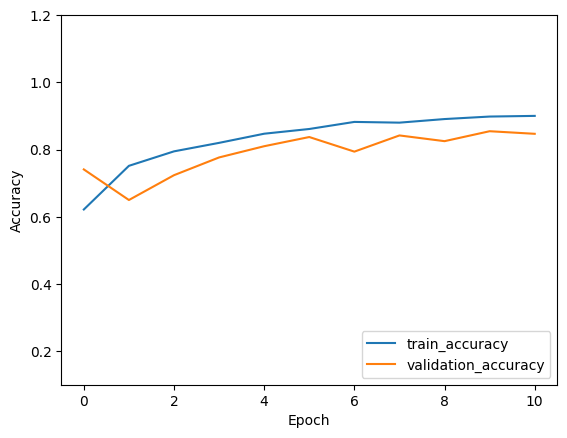

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.2])
plt.legend(loc='lower right')

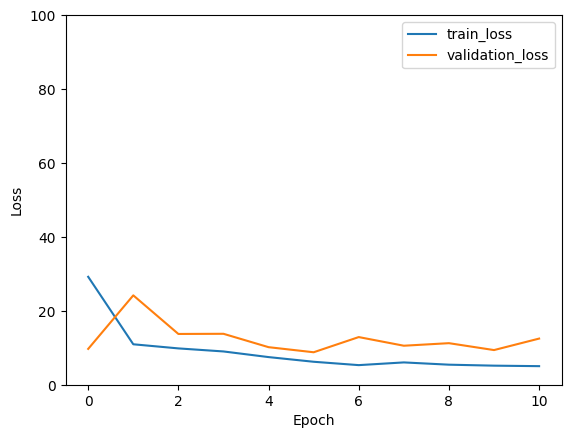

In [8]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 100])
plt.legend(loc='upper right')

2/2 [==============================] - 5s 4s/step


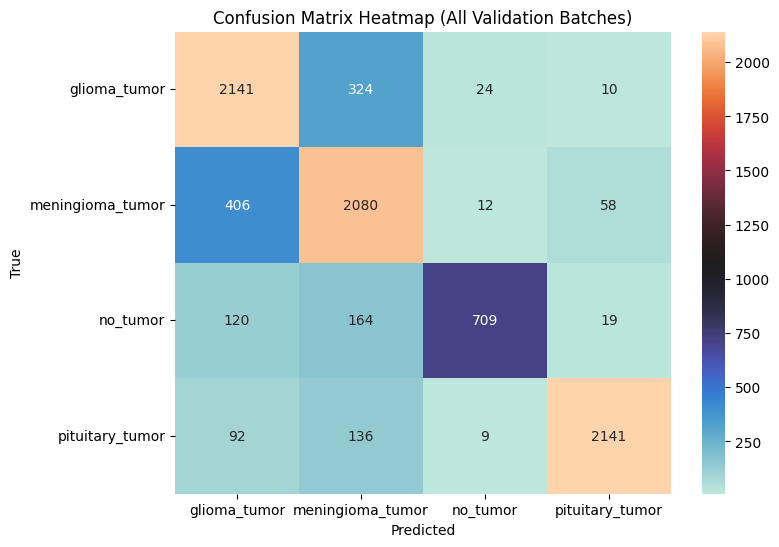

In [9]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

all_val_labels = []
all_val_predictions = []

# Evaluate the model on the validation dataset batch by batch
for batch in val_ds:
    val_images, val_labels_batch = batch
    val_predictions_batch = model.predict(val_images)

    val_labels_batch = np.array(val_labels_batch)
    val_predictions_batch = np.argmax(val_predictions_batch, axis=-1)

    all_val_labels.extend(val_labels_batch)
    all_val_predictions.extend(val_predictions_batch)

# Calculate the confusion matrix for all validation data
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (All Validation Batches)')
plt.show()

In [10]:
print(classification_report(all_val_labels, all_val_predictions, target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.78      0.86      0.81      2499
meningioma_tumor       0.77      0.81      0.79      2556
        no_tumor       0.94      0.70      0.80      1012
 pituitary_tumor       0.96      0.90      0.93      2378

        accuracy                           0.84      8445
       macro avg       0.86      0.82      0.83      8445
    weighted avg       0.85      0.84      0.84      8445

